 # Reinforcement Learning for arm manipulator

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW4 folder, then 'ROB498/HW4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Learning_and_Control/HW6/HW6'

### Setup Code

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw6.ipynb', 'panda_pushing_env.py', 'visualizers.py', 'pushing_rl.py']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

All required files are found :)


In [6]:
# Install missing required packages
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install stable-baselines -- For RL implementations
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [7]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Reinforcement Learning for Planar Pushing

We will use PPO to learn a policy for the block planar pushing task. For more details about the PPO implementation, check out the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) page.


# 1 - PPO on Object Pose Space:

In [8]:
from panda_pushing_env import PandaPushingEnv, TARGET_POSE, OBSTACLE_CENTRE, OBSTACLE_HALFDIMS, BOX_SIZE
from visualizers import GIFVisualizer, NotebookVisualizer

from pushing_rl import *

## Obstacle Free Pushing
In this section I will implement a reward function for the RL algorithm for the case where there are no obstacles on the table. 

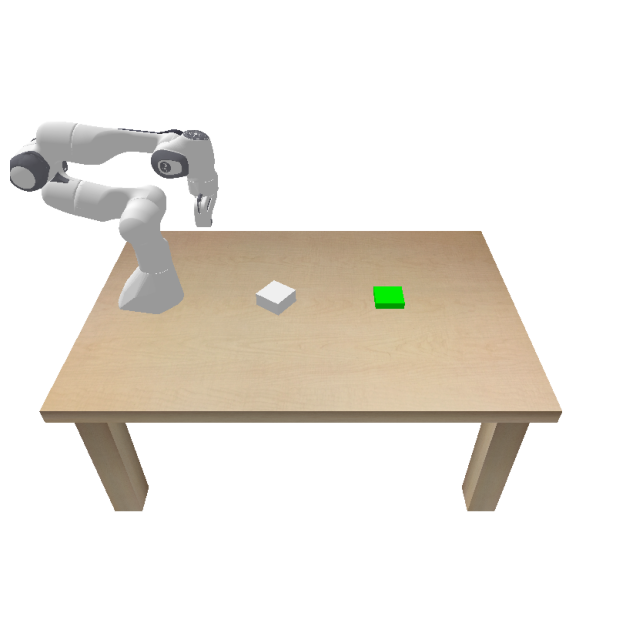

In [ ]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=3,
                                camera_heigh=800,
                                camera_width=800)
env.reset()


# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)
states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=10)

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')

### Apply Stable Baselines:

In [17]:
!pip install shimmy[gym]

In [18]:
total_timesteps = 25000 # You may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space)
env.reset()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=total_timesteps, progress_bar=True)
model.save("free_pushing_object_pose")

  56% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13,917/25,000  [ 2:59:55 < 2:41:08 , 1 it/s ]

Visualize the learned policy performance:

In [ ]:
%matplotlib inline
model = PPO.load("free_pushing_object_pose")
# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                camera_heigh=800,
                                camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, model, num_steps)

print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)

## Pushing with Obstacles
In this section I will implement a reward function for the RL algorithm for the case where there is an obstacle on the table.

In [ ]:
# visualize the obstacle env
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space,
                                include_obstacle=True,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=5,
                                camera_heigh=800,
                                camera_width=800)
env.reset()



# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)

states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=3)

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')


In [ ]:
total_timesteps = 50000 # You may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space, include_obstacle=True)
env.reset()
obstacle_policy_model = PPO("MlpPolicy", env, verbose=1)
obstacle_policy_model.learn(total_timesteps=total_timesteps, progress_bar=True)
obstacle_policy_model.save("obstacle_pushing_object_pose")

Visualize the performance:

In [ ]:
%matplotlib inline
obstacle_policy_model = PPO.load("free_pushing_object_pose")

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space,
                                include_obstacle=True,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=5,
                                camera_heigh=800,
                                camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, obstacle_policy_model, num_steps)

print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)